# **Problem Formulation**

# What is the input?

the input data representing Reddit Fake Post Detection (by Looking Only at the Title)

* conisting of only one feature that represent the title of the posts

* this data doesn't contain any missing data but contain some noise in the text which need to be cleaned and preprocessed

# What is the output?

The output is the label that specify if the post in Reddit is fack or not

label contain the prediction of the probability (0-1, float)

# What data mining function is required?
As I understand from this part of the slide

Data Mining Functions
1. Generalization and Summarization
2. Association and Correlation
3. Classification & Prediction
4. Clustering
5. Outlier/Anomaly Analysis
6. Time and Ordering 
7. Structure and Network Analysis

The data mining in this problem requires Classification & Prediction After cleaning the data by:

handeling any missing data
removing duplications
removing useless data (sach as text that contain very low number of characters)
using the regular expression library (re)

# What could be the challenges?
The Challenges represented in:

Missing data
Noise data (sach as text that contain very low number of characters)
Dealing with text feature by preprocessing and preparing it before building the models
label that contain values out of 0 and 1

# What is the impact?
The impact of using the raw data as it is, without cleaning and reprocessing, will result a model with low accuracy that doesn't learn well or a desired from the data in the traing stage


---


The real-life impact of building a model that solve this problem is represent in limitting the number of fack posts that could be created and posted on Reddit site by detecting it and distinguish it from the real ones. only by looking at the Title.


As the False information on the Internet has caused many social problems due to the raise of social network and its role in different domains such as politics.


Solving this problem will lead to avoid the spreeding of these fack news

# What is an ideal solution?
the ideal solution is to clean and preprocess the data before working with it


* Using word-level vectorizer instead of character-level vectorizer as it gives higher performance score while training
* Try different model with different hyperparamter search methods and different experimental protocols to obtain an ideal solution
* The best model that gives higher performance score was LogisticRegression followed by XGBClassifier_Pipeline_RandomizedSearchCV_with_validation_set

# What is the experimental protocol used and how was it carried out?

After loading the data and cleaning and preprocessing it, different experimental protocol are used through different trials:

using cross_val_score to measure the performance while using any classifier with character-level vectorizer and word-level vectorizer
using hyperparamter search method (RandomizedSearchCV) with validation set
setting value for k-fold cross validation cv while using GridSearchCV / RandomizedSearchCV / or BayesSearchCV and measure the perormance using (roc_auc)

# What preprocessing steps are used?

* view the data and understand it
* using df.info() to get more insight about the data
* check the missing data using df.isna().sum()
* removing rows that contain lable = 2
* handeling the text feature by applying clean_text function in order to * preprocesse and prepare it before building the models through
 * remove any html tags (< /br> often found)
 * Keep only ASCII + European Chars and whitespace, no digits
 * remove single letter chars
 * convert all whitespaces (tabs etc.) to single wspace
 *  if not for embedding (but e.g. tdf-idf):
    * all lowercase
    * remove stopwords, punctuation and stemm

 *  remove text that contain very low number of characters (consider it useless data)
 * apply feature creation with TF-IDF (word vectorizer & character vectorizer)

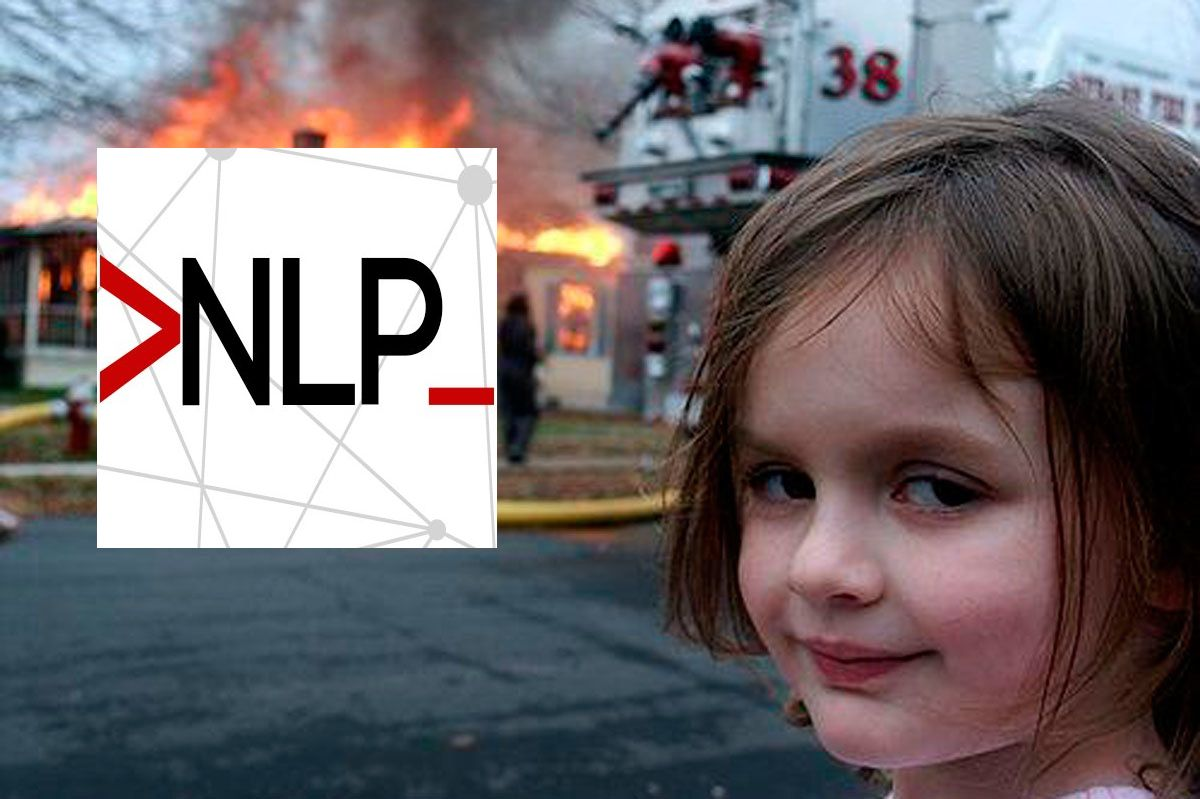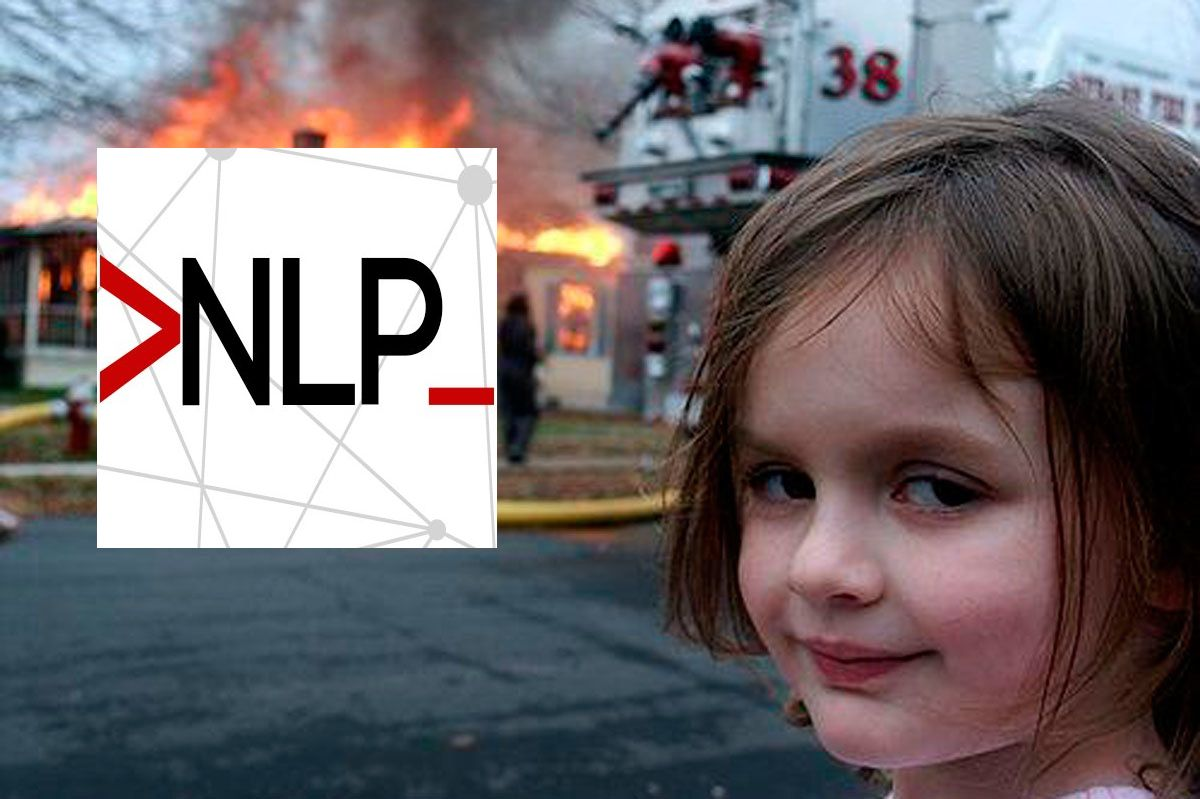


# **Import packages**

In [ ]:
!pip install scikit-optimize
!pip install xgboost
!pip install nltk
!pip install seaborn

In [ ]:
import pandas as pd
import numpy as np

# Preparing some tools for word preprocessing 
import re
import pickle
import sklearn
import pandas as pd
import numpy as np

import nltk 
from bokeh.io import output_notebook
output_notebook()

from pathlib import Path

# Importing more tools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC

from bokeh.models import NumeralTickFormatter

Loading BokehJS ...

In [ ]:
#Load the training dataset 
df  = pd.read_csv("xy_train.csv")
df_test = pd.read_csv("x_test.csv")

In [ ]:
# Saving our ids in idfor later use
id=df_test['id']


In [ ]:
# to show the first 
df.head(5)

id                                               text  label
0  265723  A group of friends began to volunteer at a hom...      0
1  284269  British Prime Minister @Theresa_May on Nerve A...      0
2  207715  In 1961, Goodyear released a kit that allows P...      0
3  551106  Happy Birthday, Bob Barker! The Price Is Right...      0
4    8584  Obama to Nation: 聙"Innocent Cops and Unarmed Y...      0

In [ ]:
# to know the shape of training dataset

df.shape

(60000, 3)

In [ ]:
# drop id column from training dataset
df = df.drop(columns=['id'])

df_test.drop(columns=['id'],axis='columns', inplace=True)
     

In [ ]:
# show the information of the train dataset
df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 60000 entries, 0 to 59999

Data columns (total 2 columns):

 #   Column  Non-Null Count  Dtype 

---  ------  --------------  ----- 

 0   text    60000 non-null  object

 1   label   60000 non-null  int64 

dtypes: int64(1), object(1)

memory usage: 937.6+ KB


In [ ]:
# check if there any missing values and counting them for each feature
df.isna().sum()


text     0
label    0
dtype: int64

In [ ]:

# Distribution of label
df["label"].value_counts(normalize=True)

0    0.536200
1    0.459933
2    0.003867
Name: label, dtype: float64

In [ ]:

# Drop rows that contain lable = 2 
df = df[(df["label"] != 2)]
df

text  label
0      A group of friends began to volunteer at a hom...      0
1      British Prime Minister @Theresa_May on Nerve A...      0
2      In 1961, Goodyear released a kit that allows P...      0
3      Happy Birthday, Bob Barker! The Price Is Right...      0
4      Obama to Nation: 聙"Innocent Cops and Unarmed Y...      0
...                                                  ...    ...
59995  Finish Sniper Simo H盲yh盲 during the invasion o...      0
59996  Nigerian Prince Scam took $110K from Kansas ma...      1
59997  Is It Safe To Smoke Marijuana During Pregnancy...      0
59998  Julius Caesar upon realizing that everyone in ...      0
59999  Jeff Bridges Releasing 鈥楽leeping Tapes,鈥?a New...      1

[59768 rows x 2 columns]

# Text cleaning and processing steps-

* Remove punctuations
* Convert text to tokens
* Remove stopwords using NLTK corpus stopwords list to match
* Apply stemming 
* Convert words to feature vectors

In [ ]:

# some seeting for pandas and hvplot
# set max_columns by 100
pd.options.display.max_columns = 100
# set max_rows by 300
pd.options.display.max_rows = 300
# set max_colwidth by 100
pd.options.display.max_colwidth = 100
np.set_printoptions(threshold=2000)

**Stemming:** It is the process of reducing the word to its word stem that affixes to suffixes and prefixes or to roots of words known as a lemma. In simple words stemming is reducing a word to its base word or stem in such a way that the words of similar kind lie under a common stem. For example – The words care, cared and caring lie under the same stem ‘care’. Stemming is important in natural language processing(NLP).

In [ ]:
# download punkt
nltk.download('punkt')
# download stopwords
nltk.download('stopwords')

#Choosing the steemmer language english
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words("english")) #stopwords


def clean_text(text, for_embedding=False):
    # do some Appropriate regex 
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
        # Keep punctuation
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)
  # do Tokenize for text
    word_tokens = word_tokenize(text)
     # convert words to lower case 
    words_tokens_lower = [word.lower() for word in word_tokens]

    if for_embedding:
        # no stemming, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_filtered = [
# Apply stemming to convert tokens to their root form. 
#This is a rule-based process of word form conversion 
#where word-suffixes are truncated irrespective of whether the root word is an actual word in the language dictionary.
        
            stemmer.stem(word) for word in words_tokens_lower if word not in stop_words 
            
            ]

    text_clean = " ".join(words_filtered)
    return text_clean

[nltk_data] Downloading package punkt to

[nltk_data]     C:\Users\LAB\AppData\Roaming\nltk_data...

[nltk_data]   Package punkt is already up-to-date!

[nltk_data] Downloading package stopwords to

[nltk_data]     C:\Users\LAB\AppData\Roaming\nltk_data...

[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Clean texts for train dataset
df["text_clean"] = df.loc[df["text"].str.len() > 20, "text"]
df["text_clean"] = df["text_clean"].map(
    lambda x: clean_text(x, for_embedding=False) if isinstance(x, str) else x
)
df

text  \
0      A group of friends began to volunteer at a homeless shelter after their neighbors protested. "Se...   
1      British Prime Minister @Theresa_May on Nerve Attack on Former Russian Spy: "The government has c...   
2      In 1961, Goodyear released a kit that allows PS2s to be brought to heel. https://m.youtube.com/w...   
3      Happy Birthday, Bob Barker! The Price Is Right Host on How He'd Like to Be Remembered | "As the ...   
4      Obama to Nation: 聙"Innocent Cops and Unarmed Young Black Men Should Not be Dying Before Magic Jo...   
...                                                                                                    ...   
59995                Finish Sniper Simo H盲yh盲 during the invasion of Finland by the USSR (1939, colorized)   
59996                Nigerian Prince Scam took $110K from Kansas man; 10 years later, he's getting it back   
59997                Is It Safe To Smoke Marijuana During Pregnancy? You鈥檇 Be Surprised Of The Answer | no   
59998                Julius Caesar upon realizing that everyone in the room has a knife except him (44 bc)   
59999                Jeff Bridges Releasing 鈥楽leeping Tapes,鈥?a New Album Designed to Help You Fall Asleep   

       label  \
0          0   
1          0   
2          0   
3          0   
4          0   
...      ...   
59995      0   
59996      1   
59997      0   
59998      0   
59999      1   

                                                                                                text_clean  
0      group friend began volunt homeless shelter neighbor protest see anoth person also need natur lik...  
1      british prime minist theresa may nerv attack former russian spi govern conclud high like russia ...  
2      goodyear releas kit allow ps brought heel https youtub com watch alxulk cg zwillc fish midatlant...  
3      happi birthday bob barker price right host like rememb man said ave pet spay neuter fuckincorpor...  
4      obama nation innoc cop unarm young black men die magic johnson jimbobshawobodob olymp athlet sho...  
...                                                                                                    ...  
59995                                                       finish sniper simo yh invas finland ussr color  
59996                                               nigerian princ scam took kansa man year later get back  
59997                                                         safe smoke marijuana pregnanc surpris answer  
59998                                               julius caesar upon realiz everyon room knife except bc  
59999                                        jeff bridg releas leep tape new album design help fall asleep  

[59768 rows x 3 columns]

In [ ]:
# # Clean texts for test data
df_test["text_clean"] = df_test.loc[df_test["text"].str.len() > 0, "text"]
df_test["text_clean"] = df_test["text_clean"].map(
    lambda x: clean_text(x, for_embedding=False) if isinstance(x, str) else x
)
df_test

text  \
0                                                                           stargazer    
1                                                                                 yeah   
2                           PD: Phoenix car thief gets instructions from YouTube video   
3                       As Trump Accuses Iran, He Has One Problem: His Own Credibility   
4                                                         "Believers" - Hezbollah 2011   
...                                                                                ...   
59146                                                Bicycle taxi drivers of New Delhi   
59147                             Trump blows up GOP's formula for winning House races   
59148  Napoleon returns from his exile on the island of Elba. (March 1815), Colourised   
59149                                 Deep down he always wanted to be a ballet dancer   
59150                        Toddler miraculously survives 6-story fall landing on car   

                                            text_clean  
0                                              stargaz  
1                                                 yeah  
2       pd phoenix car thief get instruct youtub video  
3                 trump accus iran one problem credibl  
4                                     believ hezbollah  
...                                                ...  
59146                     bicycl taxi driver new delhi  
59147             trump blow gop formula win hous race  
59148  napoleon return exil island elba march colouris  
59149                    deep alway want ballet dancer  
59150       toddler miracul surviv stori fall land car  

[59151 rows x 2 columns]

In [ ]:
# Drop when any of x missing
df = df[(df["text_clean"] != "") & (df["text_clean"] != "null")]
# drop nan v
df = df.dropna(axis="index", ).reset_index(drop=True)


In [ ]:
# display df
df

text  \
0      A group of friends began to volunteer at a homeless shelter after their neighbors protested. "Se...   
1      British Prime Minister @Theresa_May on Nerve Attack on Former Russian Spy: "The government has c...   
2      In 1961, Goodyear released a kit that allows PS2s to be brought to heel. https://m.youtube.com/w...   
3      Happy Birthday, Bob Barker! The Price Is Right Host on How He'd Like to Be Remembered | "As the ...   
4      Obama to Nation: 聙"Innocent Cops and Unarmed Young Black Men Should Not be Dying Before Magic Jo...   
...                                                                                                    ...   
59753                Finish Sniper Simo H盲yh盲 during the invasion of Finland by the USSR (1939, colorized)   
59754                Nigerian Prince Scam took $110K from Kansas man; 10 years later, he's getting it back   
59755                Is It Safe To Smoke Marijuana During Pregnancy? You鈥檇 Be Surprised Of The Answer | no   
59756                Julius Caesar upon realizing that everyone in the room has a knife except him (44 bc)   
59757                Jeff Bridges Releasing 鈥楽leeping Tapes,鈥?a New Album Designed to Help You Fall Asleep   

       label  \
0          0   
1          0   
2          0   
3          0   
4          0   
...      ...   
59753      0   
59754      1   
59755      0   
59756      0   
59757      1   

                                                                                                text_clean  
0      group friend began volunt homeless shelter neighbor protest see anoth person also need natur lik...  
1      british prime minist theresa may nerv attack former russian spi govern conclud high like russia ...  
2      goodyear releas kit allow ps brought heel https youtub com watch alxulk cg zwillc fish midatlant...  
3      happi birthday bob barker price right host like rememb man said ave pet spay neuter fuckincorpor...  
4      obama nation innoc cop unarm young black men die magic johnson jimbobshawobodob olymp athlet sho...  
...                                                                                                    ...  
59753                                                       finish sniper simo yh invas finland ussr color  
59754                                               nigerian princ scam took kansa man year later get back  
59755                                                         safe smoke marijuana pregnanc surpris answer  
59756                                               julius caesar upon realiz everyon room knife except bc  
59757                                        jeff bridg releas leep tape new album design help fall asleep  

[59758 rows x 3 columns]

# Descriptive analysis
Even though we deal with texts, we should still use some descriptive analysis to get a better understanding of the data:

In [ ]:

# Word Frequency of most common words
word_freq = pd.Series(" ".join(df["text_clean"]).split()).value_counts()
word_freq[1:40]
# to know Length of word_freq
len(word_freq)

40373

In [ ]:
# list most uncommon words
word_freq[-10:].reset_index(name="freq")

index  freq
0         afforest     1
1           muster     1
2        schwerner     1
3            zabol     1
4         cockburn     1
5           lectil     1
6  renewableenergi     1
7          kluusto     1
8        cynicalaa     1
9     licoricemeat     1

# TF-IDF

In [ ]:

# Compute unique word vector with frequencies

# use pairs of two words (ngram) = 12

vectorizer = TfidfVectorizer(
    analyzer="word", max_df=0.3, min_df=10, ngram_range=(1, 2), norm="l2"
)
vectorizer.fit(df["text_clean"])

TfidfVectorizer(max_df=0.3, min_df=10, ngram_range=(1, 2))

In [ ]:
import pandas as pd
# convert word_vector to Series pandas
word_vector = pd.Series(vectorizer.vocabulary_).sample(5, random_state=1)
print(f"Unique word (ngram) vector extract:\n\n {word_vector}")

Unique word (ngram) vector extract:



 eli       2666

go far    3595

bamboo     650

wisdom    9837

pocket    6705

dtype: int64


In [ ]:
#Checking missing values
def missing_values(data1):
    missing=pd.DataFrame(data1.isnull().sum()/len(data1))*100
    missing.columns = ['missing_values(%)']
    missing['missing_values(numbers)'] = pd.DataFrame(data1.isnull().sum())
    return missing.sort_values(by='missing_values(%)', ascending=False)
missing_values(df_test)

missing_values(%)  missing_values(numbers)
text                      0.0                        0
text_clean                0.0                        0

# modeling

In [ ]:
#Setting X train and y actual and X test

X_train = df["text_clean"]
Y_train = df["label"]
X_test = df_test["text_clean"]
# to show shape of X_train
print(X_train.shape)
# to show shape of X_test
print(X_test.shape)

(59758,)

(59151,)


# Trial_1 using LogisticRegression  with GridSearchCV

**Expectations:**

* The code creates a pipeline for feature creation and modeling using 
TfidfVectorizer and LogisticRegression respectively.
* The code defines a parameter space to test for the TfidfVectorizer, including 
ngram range, max_df, and min_df.
* The code uses Grid Search to find the best combination of hyperparameters for 
the pipeline.
* The code evaluates the model using roc_auc and sets the number of jobs to 2 for parallel processing.

**Observations:**

* The code may take a long time to run since it searches for all possible combinations of hyperparameters in the defined parameter space.
* The code may produce a high-performing model if the best combination of hyperparameters is found.
* The code may require further optimization or adjustments if the model performance is not satisfactory.

In [ ]:
# models to test
classifiers = [
    # Trial_1 using XGBClassifier  with random search 
    LinearSVC(random_state=1),
    RandomForestClassifier(random_state=1),
    XGBClassifier(random_state=1),
    MLPClassifier(
        random_state=1,
        solver="adam",
        hidden_layer_sizes=(12, 12, 12),
        activation="relu",
        early_stopping=True,
        n_iter_no_change=1,
    ),
]
# get names of the objects in list (too lazy for c&p...)
names = [re.match(r"[^\(]+", name.__str__())[0] for name in classifiers]
print(f"Classifiers to test: {names}")

Classifiers to test: ['LinearSVC', 'RandomForestClassifier', 'XGBClassifier', 'MLPClassifier']


In [ ]:

# feature creation and modelling in a single function

pipe = Pipeline(
    [
                 ("tfidf", TfidfVectorizer()), 
                 ("log", LogisticRegression())])
                 

# define parameter space to test # runtime 3hrs
params = {
    "tfidf__ngram_range": [(1, 2), (1, 3)],
    "tfidf__max_df": np.arange(0.3, 0.8),
    "tfidf__min_df": np.arange(5, 100),
   
}
# use Grid Search So it will be slow because it search for all possible trail
pipe_clf =GridSearchCV(
    pipe, params, n_jobs=2, scoring="roc_auc", cv=4) # i used roc_auc to evaluate model ,  and set n_jobs by 2
pipe_clf.fit(X_train, Y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.



Increase the number of iterations (max_iter) or scale the data as shown in:

    https://scikit-learn.org/stable/modules/preprocessing.html

Please also refer to the documentation for alternative solver options:

    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

  n_iter_i = _check_optimize_result(


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('log', LogisticRegression())]),
             n_jobs=2,
             param_grid={'tfidf__max_df': array([0.3]),
                         'tfidf__min_df': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
       73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                         'tfidf__ngram_range': [(1, 2), (1, 3)]},
             scoring='roc_auc')

In [ ]:
# to print the best parameters
print(pipe_clf.best_params_)

{'tfidf__max_df': 0.3, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 2)}


In [ ]:
#this cell to save  the output after using test dataset in the above model
submission = pd.DataFrame()

submission['id'] = id

submission['label'] = pipe_clf.predict_proba(df_test['text_clean'])[:,1]

submission.to_csv('Log_grid.csv', index=False)

0.83741 in public kaggle

# Trial_2 using XGBClassifier  with random search and validation set

**Expectations:**

* The code creates a pipeline for feature creation and modeling using TfidfVectorizer and XGBClassifier respectively.
* The code defines a parameter space to test for the TfidfVectorizer, including ngram range, max_df, and min_df.
* The code defines a parameter space to test for the XGBClassifier, including n_estimators and max_depth.
* The code uses Randomized Search to randomly sample a portion of the parameter space to find the best combination of hyperparameters for the pipeline.
* The code evaluates the model using roc_auc and sets the number of jobs to 2 for parallel processing.

**Observations:**

* The code may take a shorter time to run compared to Grid Search since it randomly samples a portion of the parameter space.
* The code may still produce a high-performing model if the best combination of hyperparameters is found, especially if the parameter space is well-defined.
* The code may require further optimization or adjustments if the model performance is not satisfactory.
* The number of iterations in Randomized Search (n_iter) can affect the search space and ultimately the quality of the selected parameters.

In [ ]:

pipe = Pipeline(
    [
                 ("tfidf", TfidfVectorizer()), 
                 ("XGC", XGBClassifier())])
                 

# define parameter space to test # runtime 35min
params = {
    #The lower and upper boundary of the range of n-values for different n-gram
    "tfidf__ngram_range": [(1, 2), (1, 3)],
    #When building the vocabulary ignore terms that have a document frequency strictly higher than the given thresho
    "tfidf__max_df": np.arange(0.3, 0.8),
    #When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. 
    "tfidf__min_df": np.arange(5, 100),
     # n_estimators
    'XGC__n_estimators': [200, 300, 400],  
      # max depth
    'XGC__max_depth':[8,9,10,11]     
    
}
# i use in this trail RandomizedSearchCV
pipe_clf = RandomizedSearchCV(
    pipe, params, n_jobs=2, scoring="roc_auc", n_iter=3) # n_iter=3 , it will for the three of all compination
pipe_clf.fit(X_train, Y_train)                           # use roc_auc to evaluate model

In [ ]:
#this cell to save  the output after using test dataset in the above model
submission = pd.DataFrame()

submission['id'] = id

submission['label'] = pipe_clf.predict_proba(df_test['text_clean'])[:,1]

submission.to_csv('XGB_Random.csv', index=False)

# trail_3 MLPClassifier with word-level vectorizer

The code evaluates the performance of the MLPClassifier model using cross-validation and the roc_auc score. The MLPClassifier algorithm is a neural network-based algorithm that can learn complex non-linear relationships in the data. The specified hyperparameters can affect the performance of the model.

In [ ]:
# transform each sentence to numeric vector with tf-idf value as elements
X_train_vec = vectorizer.transform(X_train)
test_vec = vectorizer.transform(df_test['text_clean'])
X_train_vec.get_shape()

(59758, 10061)

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
#%%time

# Class MLPClassifier implements a multi-layer perceptron (MLP)
# algorithm that trains using Backpropagation.
clf = MLPClassifier(
        random_state=1,
        solver="adam",
        hidden_layer_sizes=(12, 12, 12),
        activation="relu",
        early_stopping=True,
        n_iter_no_change=1,
    )
scores = cross_val_score(clf, X_train_vec, Y_train, scoring="roc_auc", cv=5)
print(scores.mean())

0.8652354849190687


In [ ]:
#%%time
clf.fit(X_train_vec, Y_train)

MLPClassifier(early_stopping=True, hidden_layer_sizes=(12, 12, 12),
              n_iter_no_change=1, random_state=1)

In [ ]:
  #this cell to save  the output after using test dataset in the above model

  submission = pd.DataFrame()

  submission['id'] = id

  submission['label'] = clf.predict_proba(test_vec)[:,1]

  submission.to_csv("MLP_word", index=False)

# it give me in public kaggel 0.81845

plan 
# I'm going to use the xgboost model

# Trail_4

In [ ]:
import xgboost as xgb

In [ ]:
pipe = Pipeline([("tfidf", TfidfVectorizer("char")),  ('xgb_model',xgb.XGBClassifier())])

params = {
    
    "tfidf__ngram_range": [(1, 4),(2,5)], # The lower and upper boundary of the range of n-values for different n-grams to be extracted. 
    "tfidf__max_df": np.arange(0.6, 0.8),#When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold 
    "tfidf__min_df": np.arange(5,30),#When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. 
    'xgb_model__min_child_weight': [1, 5, 10], #The number of samples required to form a leaf node 
    'xgb_model__gamma': [0.5, 1, 1.5, 2, 5],
    'xgb_model__subsample': [0.6, 0.8, 1.0], 
    'xgb_model__colsample_bytree': [0.6, 0.8, 1.0],.
    'xgb_model__max_depth': [3, 4, 5]# how deep each estimator is permitted to build a tree.
}

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass input=char as keyword args. From version 0.25 passing these as positional arguments will result in an error

  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [ ]:
random_search_xg = RandomizedSearchCV(
    pipe, params, cv=3, verbose=1, n_jobs=2, 
    # number of random trials
    n_iter=10,
    scoring='roc_auc')## use roc_auc to evaluate model

#fitting model by using X_train and Y_train
random_search_xg.fit(X_train,Y_train) 
#printing  best scores
print('best score {}'.format(random_search_xg.best_score_)) 
#printing best hyperparameters
print('best hyperparameter {}'.format(random_search_xg.best_params_)) 

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.

[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  1.2min finished


best score 0.8032208982587895

best hyperparameter {'xgb_model__subsample': 0.6, 'xgb_model__min_child_weight': 1, 'xgb_model__max_depth': 4, 'xgb_model__gamma': 1, 'xgb_model__colsample_bytree': 1.0, 'tfidf__ngram_range': (1, 4), 'tfidf__min_df': 19, 'tfidf__max_df': 0.6}


In [ ]:
  #this cell to save  the output after using test dataset in the above model
submission = pd.DataFrame()

submission['id'] = id

submission['label'] = random_search_xg.predict_proba(df_test['text_clean'])[:,1]

submission.to_csv("xgboost", index=False)

**the best hayperprameter**

'xgb_model__subsample': 0.6, 'xgb_model__min_child_weight': 1, 

'xgb_model__max_depth': 4, 'xgb_model__gamma': 1, 

'xgb_model__colsample_bytree': 1.0, 'tfidf__ngram_range': (1, 4), 

'tfidf__min_df': 19, 'tfidf__max_df': 0.6

# Trail_4

# Expectations:

* The code creates a pipeline that includes TfidfVectorizer and XGBClassifier for feature creation and modeling.
* TfidfVectorizer is used to convert text data into numerical vectors using word-level n-grams with a range of 1 to 2.
* XGBClassifier is used to perform classification with 40 estimators and a maximum depth of 20.
* The pipeline will be trained on x_train and y_train data.


# Observations:

* The XGB_tfidf pipeline can improve the performance of the model by converting the text data into numerical vectors using TfidfVectorizer before classification.
* The specified hyperparameters such as ngram_range, n_estimators, and max_depth can affect the performance of the model.
* The pipeline may require further optimization or adjustments if the model performance is not satisfactory.
* The pipeline may produce a high-performing model if the best combination of hyperparameters is found.

# XGBClassifier   TFIDF  WORD

In [ ]:
from sklearn.model_selection import train_test_split
# split data (training/testing set)
df_train_FS, df_val_FS = train_test_split(df, test_size=0.2, random_state=10)
     

x_train = df_train_FS.text
y_train = df_train_FS.label
x_val = df_val_FS.text
y_val = df_val_FS.label
     

print("x_train_text_FS.shape >>>> ",x_train.shape)
print("y_train_label_FS.shape >>>> ",y_train.shape)
print("x_val_text_FS.shape >>>> ",x_val.shape)
print("y_val_label_FS.shape >>>> ",y_val.shape)

x_train_text_FS.shape >>>>  (47806,)

y_train_label_FS.shape >>>>  (47806,)

x_val_text_FS.shape >>>>  (11952,)

y_val_label_FS.shape >>>>  (11952,)


In [ ]:
XGB_tfidf = Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,2),analyzer="word")), ('XGB', XGBClassifier(n_estimators=40,max_depth=20))])
#fit the model and print the score the model
XGB_tfidf.fit(x_train, y_train)  
     

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('XGB',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=20, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estima

In [ ]:
XGB_tfidf.score(x_train, y_train)

0.9005564155126972

In [ ]:
y_pred = XGB_tfidf.predict(x_val)

In [ ]:
y_pred

array([1, 1, 0, ..., 1, 0, 1])

In [ ]:
from sklearn.metrics import accuracy_score
#Accuracy
Accuracy=accuracy_score(y_val,y_pred) 
print("Accuracy:  " , (Accuracy))

Accuracy:   0.7680722891566265


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support



           0       0.82      0.73      0.77      6366

           1       0.72      0.81      0.77      5586



    accuracy                           0.77     11952

   macro avg       0.77      0.77      0.77     11952

weighted avg       0.77      0.77      0.77     11952




In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import seaborn as sns
def plot_confusion_matrix(y_test, y_pred):
  #Get the confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred,labels=[0,1])
 
  #print(cf_matrix)
     
  group_counts = ["{0:0.0f}".format(value) for value in
      cf_matrix.flatten()]

  group_percentages = ["{0:.2%}".format(value) for value in
            cf_matrix.flatten()/np.sum(cf_matrix)]

  labels = [f"{v1}\n{v2}\n" for v1, v2 in
  zip(group_counts,group_percentages)]

  labels = np.asarray(labels).reshape(2,2)

  ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

  ax.set_title('  Confusion Matrix  \n\n');
  ax.set_xlabel('\nPredicted labels')
  ax.set_ylabel('Actual labels ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels([0,1])
  ax.yaxis.set_ticklabels([0,1])

  ## Display the visualization of the Confusion Matrix.
  plt.show()

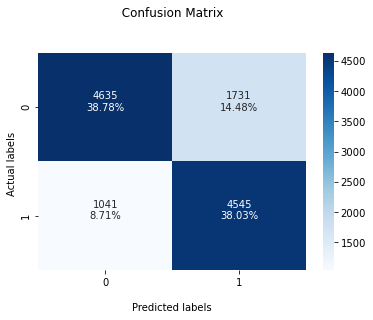

In [ ]:
from sklearn.metrics import classification_report
plot_confusion_matrix(y_val,y_pred)

In [ ]:
#visualization for roc_curve
from sklearn.metrics import roc_curve , roc_auc_score
def plot_roc_curve(y_test, y_pred):
  #calculate and virtualize the roc curve for the test set
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_pred)
  plt.plot(fpr, tpr, 'r', label = 'AUC = %0.4f' % roc_auc)
  plt.plot(fpr, tpr, color='red', label='')
  plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.legend(loc = 'lower right')
  plt.grid()
     

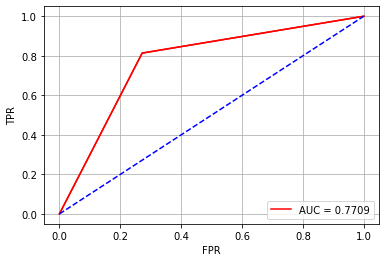

In [ ]:
plot_roc_curve(y_val,y_pred)

In [ ]:
 #this cell to save  the output after using test dataset in the above model
submission = pd.DataFrame()

submission['id'] = id

submission['label'] = XGB_tfidf.predict_proba(df_test['text_clean'])[:,1]

submission.to_csv('TFIDF_xgb.csv', index=False)

# Trail_5

# XGBClassifier   TFIDF  char

In [ ]:
XGB_tfidf_char = Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,3),analyzer="char")), ('XGB', XGBClassifier(n_estimators=40,max_depth=20))])
#fit the model and print the score the model
XGB_tfidf_char.fit(x_train, y_train)  

Pipeline(steps=[('tfidf', TfidfVectorizer(analyzer='char', ngram_range=(1, 3))),
                ('XGB',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=20, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constrain

In [ ]:
XGB_tfidf_char.score(x_train, y_train)

0.9995816424716563

In [ ]:
y_pred = XGB_tfidf_char.predict(x_val)

In [ ]:
#Accuracy
Accuracy=accuracy_score(y_val,y_pred) 
print("Accuracy:  " , (Accuracy))

Accuracy:   0.8468875502008032


In [ ]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support



           0       0.90      0.80      0.85      6366

           1       0.80      0.90      0.85      5586



    accuracy                           0.85     11952

   macro avg       0.85      0.85      0.85     11952

weighted avg       0.85      0.85      0.85     11952




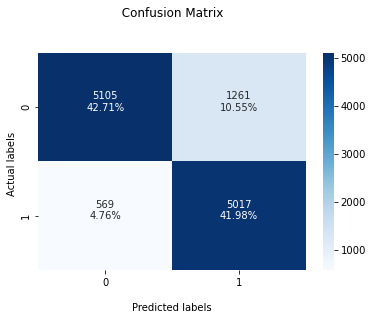

In [ ]:
plot_confusion_matrix(y_val,y_pred)


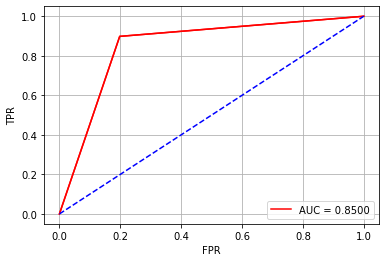

In [ ]:
plot_roc_curve(y_val,y_pred)

In [ ]:
 #this cell to save  the output after using test dataset in the above model
submission = pd.DataFrame()

submission['id'] = id

submission['label'] = XGB_tfidf_char.predict_proba(df_test['text_clean'])[:,1]

submission.to_csv('car_XGB.csv', index=False)

kaggle public 80045

# TFIDF  WORD    RandomForestClassifier

In [ ]:
tfidf_R_word = Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,2),analyzer="word")), ('RandomForestClassifier', RandomForestClassifier())])
#fit the model and print the score the model
tfidf_R_word.fit(x_train, y_train) 

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('RandomForestClassifier', RandomForestClassifier())])

In [ ]:
tfidf_R_word.score(x_train, y_train)

0.9999163284943312

In [ ]:
y_pred = tfidf_R_word.predict(x_val)

In [ ]:
#Accuracy
Accuracy=accuracy_score(y_val,y_pred) 
print("Accuracy:  " , (Accuracy))
     

Accuracy:   0.7847222222222222


In [ ]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support



           0       0.81      0.78      0.79      6366

           1       0.76      0.79      0.77      5586



    accuracy                           0.78     11952

   macro avg       0.78      0.79      0.78     11952

weighted avg       0.79      0.78      0.78     11952




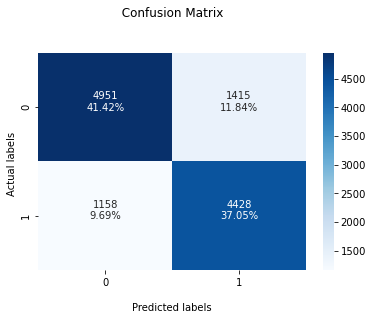

In [ ]:
plot_confusion_matrix(y_val,y_pred)

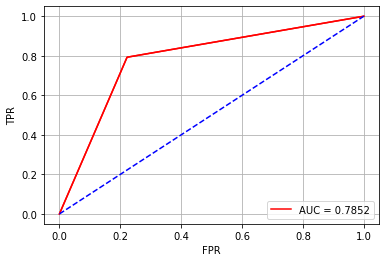

In [ ]:
plot_roc_curve(y_val,y_pred)

In [ ]:
 #this cell to save  the output after using test dataset in the above model
submission = pd.DataFrame()

submission['id'] = id

submission['label'] = tfidf_R_word.predict_proba(df_test['text_clean'])[:,1]

submission.to_csv('TFIDFword_randomsearch.csv', index=False)

kaggel in public :- 0.75251

# I'm very tireeeed

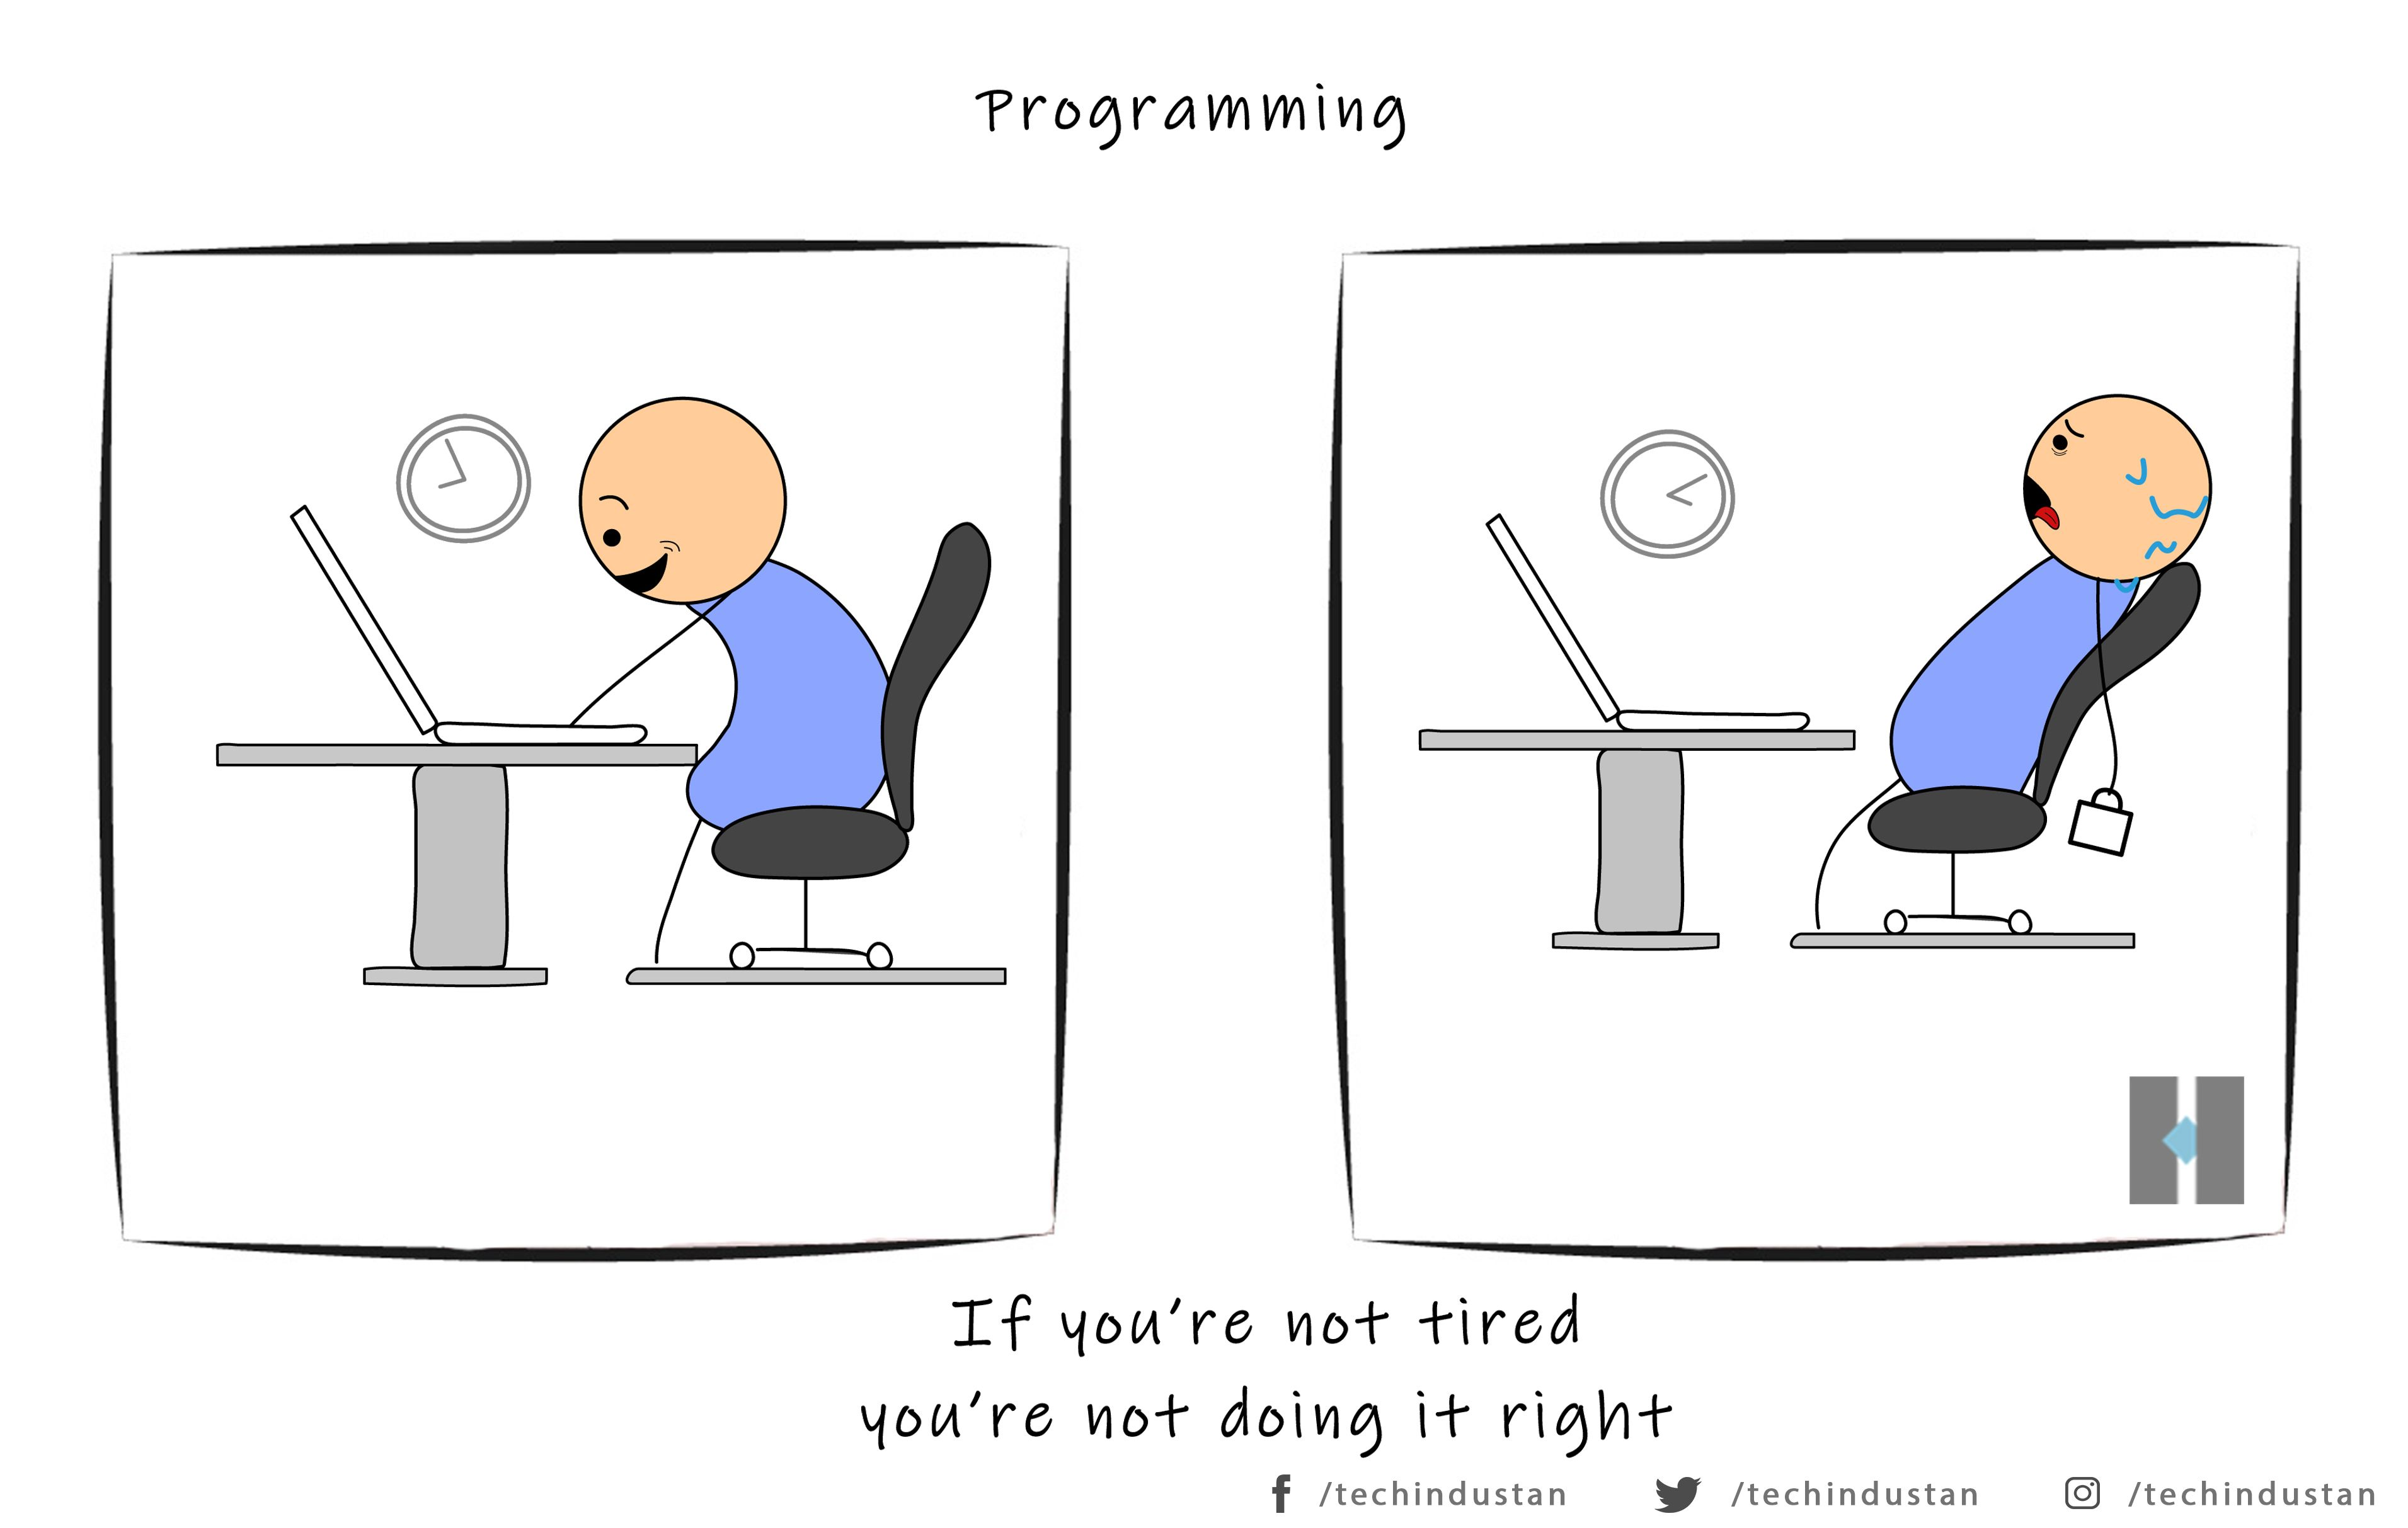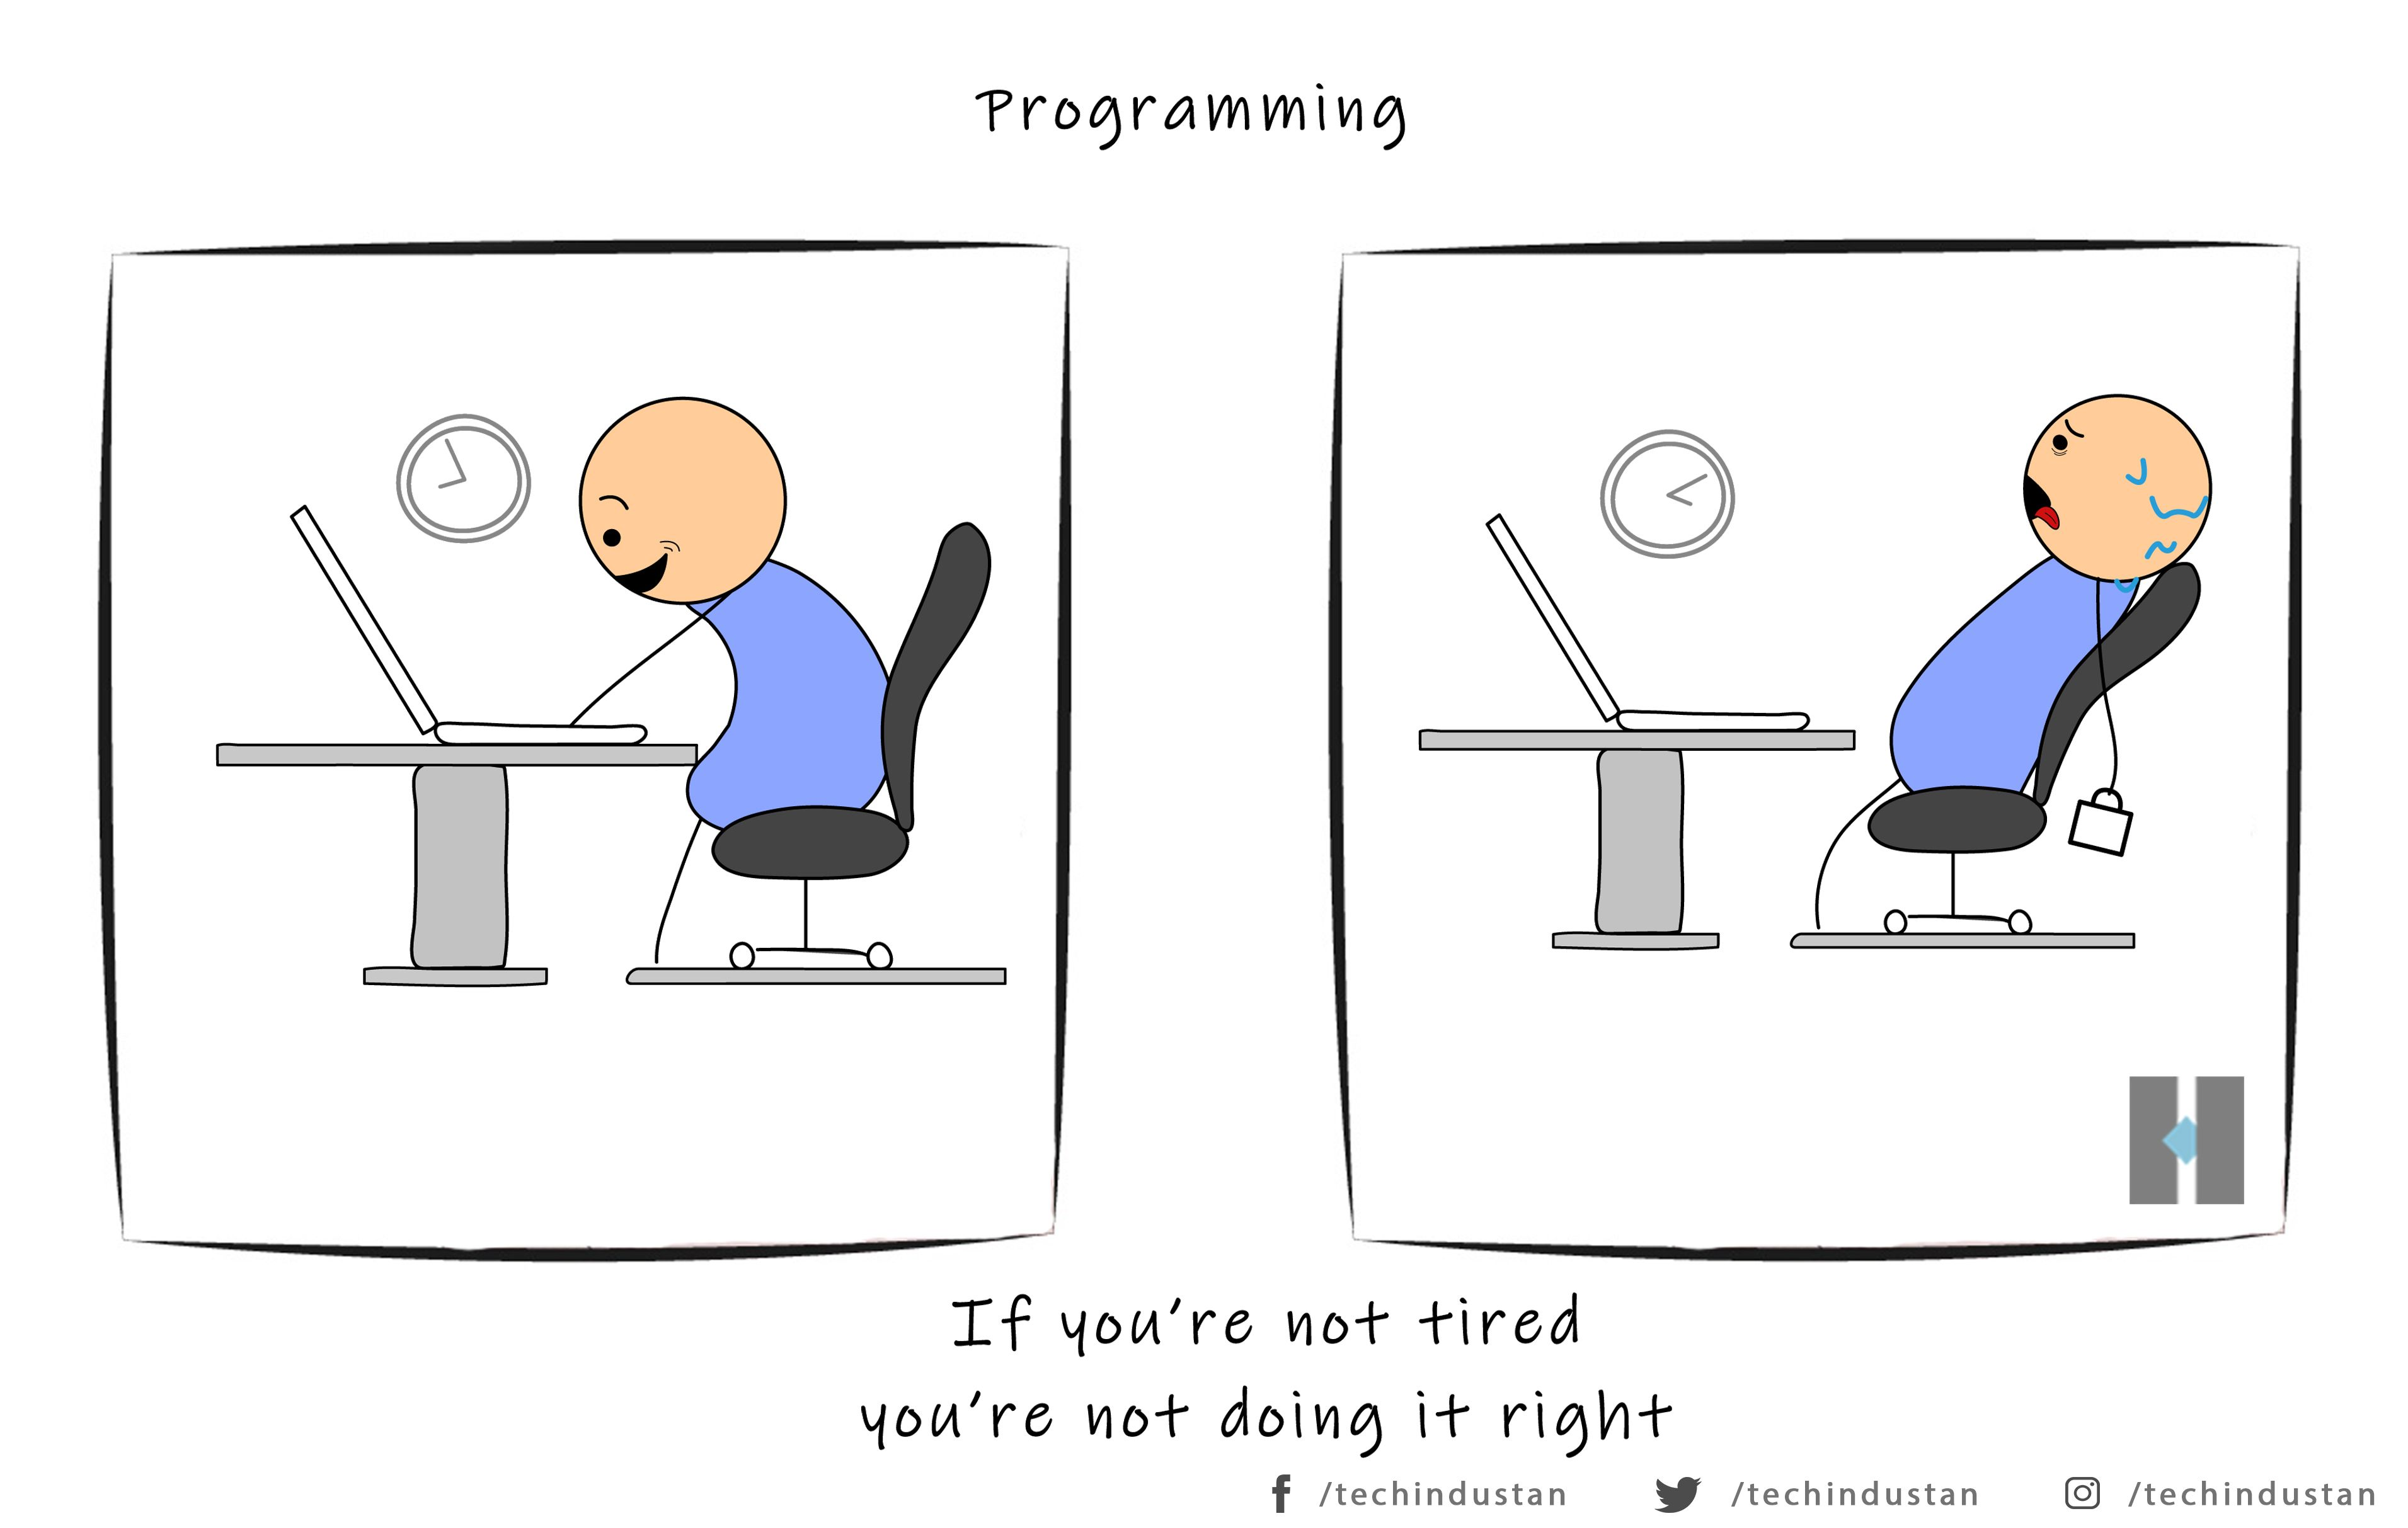

# **data preprocessing**

In [ ]:
df_Train=pd.read_csv('xy_train.csv')



In [ ]:
id_=df_Test['id']

In [ ]:

df_Train.shape

(60000, 3)

In [ ]:
df_Train.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 60000 entries, 0 to 59999

Data columns (total 3 columns):

 #   Column  Non-Null Count  Dtype 

---  ------  --------------  ----- 

 0   id      60000 non-null  int64 

 1   text    60000 non-null  object

 2   label   60000 non-null  int64 

dtypes: int64(2), object(1)

memory usage: 1.4+ MB


In [ ]:
df_Train.head()

id  \
0  265723   
1  284269   
2  207715   
3  551106   
4    8584   

                                                                                                  text  \
0  A group of friends began to volunteer at a homeless shelter after their neighbors protested. "Se...   
1  British Prime Minister @Theresa_May on Nerve Attack on Former Russian Spy: "The government has c...   
2  In 1961, Goodyear released a kit that allows PS2s to be brought to heel. https://m.youtube.com/w...   
3  Happy Birthday, Bob Barker! The Price Is Right Host on How He'd Like to Be Remembered | "As the ...   
4  Obama to Nation: 聙"Innocent Cops and Unarmed Young Black Men Should Not be Dying Before Magic Jo...   

   label  
0      0  
1      0  
2      0  
3      0  
4      0

In [ ]:
#Check the data for missing values in training data
df_Train.isnull().sum()

id       0
text     0
label    0
dtype: int64

In [ ]:
#Check the data for duplicates 
df_Train.duplicated().any()

False

In [ ]:

df_Train.shape

(60000, 3)

In [ ]:

#lets drop duplicates (if any)
df_Train.drop_duplicates(inplace=True)

In [ ]:
#check the target column 
df_Train['label'].value_counts()

0    32172
1    27596
2      232
Name: label, dtype: int64

In [ ]:
# Distribution of label
df_Train["label"].value_counts(normalize=True)

0    0.536200
1    0.459933
2    0.003867
Name: label, dtype: float64

In [ ]:

#"label" should be 0 or 1 so drop any row when "label"=2
df_Train = df_Train[df_Train.label != 2]

In [ ]:
df_Train.shape

(59768, 3)

In [ ]:
#check the target column 
df_Train['label'].value_counts()

0    32172
1    27596
Name: label, dtype: int64

In [ ]:
# Distribution of label
df_Train["label"].value_counts(normalize=True)

0    0.538281
1    0.461719
Name: label, dtype: float64

In [ ]:
#describe the text column
df_Train['text'].describe()

count                                                                                            59768
unique                                                                                           59413
top       /r/Fakehistoryporn subscribers as they attempt to read a series of basic instructions (2018)
freq                                                                                                14
Name: text, dtype: object

In [ ]:
df_Train['text'].duplicated().sum()

355

In [ ]:
#Remove the duplicated rows
df_Train.drop_duplicates('text',inplace = True)

In [ ]:

df_Train.shape

(59413, 3)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import nltk 
from nltk.stem import WordNetLemmatizer


In [ ]:
nltk.download('omw-1.4')

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')

[nltk_data] Downloading package omw-1.4 to

[nltk_data]     C:\Users\LAB\AppData\Roaming\nltk_data...

[nltk_data]   Package omw-1.4 is already up-to-date!

[nltk_data] Downloading package punkt to

[nltk_data]     C:\Users\LAB\AppData\Roaming\nltk_data...

[nltk_data]   Package punkt is already up-to-date!

[nltk_data] Downloading package stopwords to

[nltk_data]     C:\Users\LAB\AppData\Roaming\nltk_data...

[nltk_data]   Package stopwords is already up-to-date!

[nltk_data] Downloading package wordnet to

[nltk_data]     C:\Users\LAB\AppData\Roaming\nltk_data...

[nltk_data]   Package wordnet is already up-to-date!

[nltk_data] Downloading package words to

[nltk_data]     C:\Users\LAB\AppData\Roaming\nltk_data...

[nltk_data]   Package words is already up-to-date!


True

# Lemmatize using WordNet's built-in morphy function.
# Returns the input word unchanged if it cannot be found in WordNet. 

In [ ]:

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def clean_text_TS(text):
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    #RE_TWOCHARACTER=re.compile(r"\b[A-Za-zÀ-ž]\b{2}", re.IGNORECASE)
    #RE_URL=re.compile(r'^https?:\/\/.*[\r\n]*', re.IGNORECASE)
    
   # remove any html tags (< /br> often found)
    text = re.sub(RE_TAGS, " ", text)
    #Keep only ASCII + European Chars and whitespace, no digits
    text = re.sub(RE_ASCII, " ", text)
    #remove single letter chars
    text = re.sub(RE_SINGLECHAR, " ", text)
     #remove two letter chars
    #text = re.sub(RE_TWOCHARACTER, " ", text)
    #remove URL 
    #text = re.sub(RE_URL, " ", text)
    #convert all whitespaces (tabs etc.) to single wspace
    text = re.sub(RE_WSPACE, " ", text)
    #remove any digit
    text=re.sub(r'\d+', '', text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    
    # (tdf-idf):
    # - remove stopwords, punctuation and stemm
    words_filtered = [
           lemmatizer.lemmatize(word) for word in words_tokens_lower if word not in stop_words
        ]

    text_clean = " ".join(words_filtered)
    return text_clean

In [ ]:

# Clean texts for train dataset
df_Train["text_clean"] = df_Train.loc[df_Train["text"].str.len() > 20, "text"]
df_Train["text_clean"] = df_Train["text_clean"].map(
    lambda x: clean_text_TS(x) if isinstance(x, str) else x
)
df_Train    
    

id  \
0      265723   
1      284269   
2      207715   
3      551106   
4        8584   
...       ...   
59995   70046   
59996  189377   
59997   93486   
59998  140950   
59999   34509   

                                                                                                      text  \
0      A group of friends began to volunteer at a homeless shelter after their neighbors protested. "Se...   
1      British Prime Minister @Theresa_May on Nerve Attack on Former Russian Spy: "The government has c...   
2      In 1961, Goodyear released a kit that allows PS2s to be brought to heel. https://m.youtube.com/w...   
3      Happy Birthday, Bob Barker! The Price Is Right Host on How He'd Like to Be Remembered | "As the ...   
4      Obama to Nation: 聙"Innocent Cops and Unarmed Young Black Men Should Not be Dying Before Magic Jo...   
...                                                                                                    ...   
59995                Finish Sniper Simo H盲yh盲 during the invasion of Finland by the USSR (1939, colorized)   
59996                Nigerian Prince Scam took $110K from Kansas man; 10 years later, he's getting it back   
59997                Is It Safe To Smoke Marijuana During Pregnancy? You鈥檇 Be Surprised Of The Answer | no   
59998                Julius Caesar upon realizing that everyone in the room has a knife except him (44 bc)   
59999                Jeff Bridges Releasing 鈥楽leeping Tapes,鈥?a New Album Designed to Help You Fall Asleep   

       label  \
0          0   
1          0   
2          0   
3          0   
4          0   
...      ...   
59995      0   
59996      1   
59997      0   
59998      0   
59999      1   

                                                                                                text_clean  
0      group friend began volunteer homeless shelter neighbor protested seeing another person also need...  
1      british prime minister theresa may nerve attack former russian spy government concluded highly l...  
2      goodyear released kit allows p brought heel http youtube com watch alxulk cg zwillc fishing mida...  
3      happy birthday bob barker price right host like remembered man said ave pet spayed neutered fuck...  
4      obama nation innocent cop unarmed young black men dying magic johnson jimbobshawobodob olympic a...  
...                                                                                                    ...  
59995                                                finish sniper simo yh invasion finland ussr colorized  
59996                                          nigerian prince scam took kansa man year later getting back  
59997                                                      safe smoke marijuana pregnancy surprised answer  
59998                                           julius caesar upon realizing everyone room knife except bc  
59999                               jeff bridge releasing leeping tape new album designed help fall asleep  

[59413 rows x 4 columns]

In [ ]:
df_Train.shape

(59413, 4)

In [ ]:
# Drop when any of x missing
df_Train = df_Train[(df_Train["text_clean"] != "") & (df_Train["text_clean"] != "null")]

df_Train = df_Train.dropna(
    axis="index", subset=[ "text", "text_clean"]
).reset_index(drop=True)

In [ ]:
from bokeh.models import NumeralTickFormatter
# Word Frequency of most common words
word_freq = pd.Series(" ".join(df_Train["text_clean"]).split()).value_counts()
word_freq[1:40]
     

one          3274
new          2972
like         2939
man          2694
trump        2551
colorized    2419
people       2310
first        2231
old          2212
look         2208
say          2123
get          2063
time         2002
poster       1998
found        1956
day          1926
woman        1882
war          1851
life         1763
make         1726
world        1565
u            1496
american     1483
psbattle     1465
state        1381
two          1357
post         1351
school       1328
back         1319
made         1310
photo        1288
right        1266
circa        1246
child        1207
president    1194
see          1175
house        1171
know         1167
way          1160
dtype: int64

In [ ]:
word_freq[-10:].reset_index(name="freq")

index  freq
0     germania     1
1      cactuar     1
2         pyfx     1
3    bonsevich     1
4        meade     1
5    sysadmins     1
6  apparentely     1
7   lancashire     1
8      twitchy     1
9        longs     1


# Data cleaning for test data (kaggle)


In [ ]:
df_Test = pd.read_csv("x_test.csv")

In [ ]:

df_Test.shape

(59151, 2)

In [ ]:
df_Test.info()


<class 'pandas.core.frame.DataFrame'>

RangeIndex: 59151 entries, 0 to 59150

Data columns (total 2 columns):

 #   Column  Non-Null Count  Dtype 

---  ------  --------------  ----- 

 0   id      59151 non-null  int64 

 1   text    59151 non-null  object

dtypes: int64(1), object(1)

memory usage: 924.4+ KB


In [ ]:
df_Test.head()

id                                                            text
0   0                                                      stargazer 
1   1                                                            yeah
2   2      PD: Phoenix car thief gets instructions from YouTube video
3   3  As Trump Accuses Iran, He Has One Problem: His Own Credibility
4   4                                    "Believers" - Hezbollah 2011

In [ ]:
# Clean text
df_Test["text_clean"] = df_Test.loc[df_Test["text"].str.len() > 0, "text"]
df_Test["text_clean"] = df_Test["text_clean"].map(
    lambda x: clean_text_TS(x) if isinstance(x, str) else x
)
  

In [ ]:
df_Test.head()

id                                                            text  \
0   0                                                      stargazer    
1   1                                                            yeah   
2   2      PD: Phoenix car thief gets instructions from YouTube video   
3   3  As Trump Accuses Iran, He Has One Problem: His Own Credibility   
4   4                                    "Believers" - Hezbollah 2011   

                                           text_clean  
0                                           stargazer  
1                                                yeah  
2  pd phoenix car thief get instruction youtube video  
3          trump accuses iran one problem credibility  
4                                  believer hezbollah

# split the data

In [ ]:

from sklearn.model_selection import train_test_split
# split data (training/testing set)
df_train, df_val = train_test_split(df_Train, test_size=0.2, random_state=10)

In [ ]:

x_train = df_train.text_clean
y_train = df_train.label
x_val = df_val.text_clean
y_val = df_val.label

In [ ]:
print("x_train_text_TS.shape >>>> ",x_train.shape)
print("y_train_label_TS.shape >>>> ",y_train.shape)
print("x_val_text_TS.shape >>>> ",x_val.shape)
print("y_val_label_TS.shape >>>> ",y_val.shape)

x_train_text_TS.shape >>>>  (47522,)

y_train_label_TS.shape >>>>  (47522,)

x_val_text_TS.shape >>>>  (11881,)

y_val_label_TS.shape >>>>  (11881,)


trials
trial (Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,2),analyzer="word")), ('RandomForestClassifier', RandomForestClassifier())]))

In [ ]:

RF_tfidf = Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,2),analyzer="word")), ('RandomForestClassifier', RandomForestClassifier())])
#fit the model and print the score the model
RF_tfidf.fit(x_train, y_train)  
     

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('RandomForestClassifier', RandomForestClassifier())])

In [ ]:
RF_tfidf.score(x_train, y_train)

0.9999789571145996

In [ ]:
y_pred = RF_tfidf.predict(x_val)

In [ ]:

y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [ ]:
#Accuracy

from sklearn.metrics import accuracy_score
Accuracy=accuracy_score(y_val,y_pred) 
print("Accuracy:  " , (Accuracy))

Accuracy:   0.7608787139129702


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support



           0       0.78      0.78      0.78      6413

           1       0.74      0.74      0.74      5468



    accuracy                           0.76     11881

   macro avg       0.76      0.76      0.76     11881

weighted avg       0.76      0.76      0.76     11881




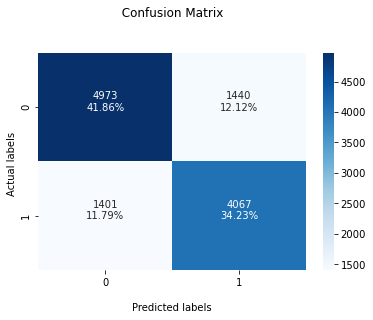

In [ ]:
plot_confusion_matrix(y_val,y_pred)

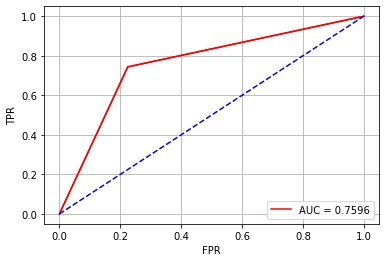

In [ ]:

plot_roc_curve(y_val,y_pred,)

In [ ]:
df_Test

0                                                   stargazer
1                                                        yeah
2          pd phoenix car thief get instruction youtube video
3                  trump accuses iran one problem credibility
4                                          believer hezbollah
                                 ...                         
59146                           bicycle taxi driver new delhi
59147               trump blow gop formula winning house race
59148      napoleon return exile island elba march colourised
59149                        deep always wanted ballet dancer
59150    toddler miraculously survives story fall landing car
Name: text_clean, Length: 59151, dtype: object

In [ ]:
 #this cell to save  the output after using test dataset in the above model
submission = pd.DataFrame()

submission['id'] = id

submission['label'] = RF_tfidf.predict_proba(df_Test['text_clean'])[:,1]

submission.to_csv('RF_tfidf.csv', index=False)

**in public kaggle:- 0.86803**

# WordNetLemmatizer  with
(Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,2),analyzer="word")), ('RandomForestClassifier', RandomForestClassifier())])) give me best accuracy on kaggel

 # What is the difference between Character n-gram and Word n-gram? Which one tends to suffer more from the OOV issue?


* Character N-Grams it is split each words based on character but word N-Grams it is split whole text based on words.

* Character N-grams split highlights some common properties that a word n-gram split does not.

* Character N-grams split allows to identify interesting similarities across languages.

* Character N-grams make languages more comparable revealing more repeated objects.

**Word n-gram tends to suffer more from OOV (Out-Of-Vocabulary) issue because of the new words that presented in the testing dataset and not appear in training dataset.**

 # What is the difference between stop word removal and stemming? Are these techniques language-dependent?


* stop word:remove all words don't carry the same amount of information, if any information at all, for a predictive modeling task. Common words that carry little (or perhaps no) meaningful information are called stop words like that , is .....
* stemming:the process of identifying the base word (or stem) for a data set of words. Stemming is concerned with the linguistics subfield of morphology, how words are formed. In this example, "trees" would lose its letter "s" while "tree" stays the same.
* yes,stop word removal and stemming algorithms are language dependent.



# Is tokenization techniques language dependent? Why?

**yes**,Tokenization is the process of breaking down a piece of text into small units called tokens. A token may be a word, part of a word or just characters like punctuation. It is one of the most foundational NLP task and a difficult one, because every language has its own grammatical constructs, which are often difficult to write down as rules.

# What is the difference between count vectorizer and tf-idf vectorizer? Would it be feasible to use all possible n-grams? If not, how should you select them?

**TfidfVectorizer and CountVectorizer both are methods for converting text data into vectors as model can process only numerical data.**

* **CountVectorizer:** Counts the frequency of all words in our corpus, sorts them and grabs the most recurring features (using max_features hyperparameter). But these results are mostly biased and our model might loose out on some of the important less frequent features. These are all boolean values.

For example: SEO People used to take advantage of this.

* **TFIDFVectorizer:** TFIDF is a statistical measure said to have fixed the issues with CountVectorizer in some way. It consists of 2 parts, TF (Term Frequency) multiplied with IDF (Inverse Document Frequency). The main intuition being some words that appear frequently in 1 document and less frequently in other documents could be considered as providing extra insight for that 1 document and could help our model learn from this additional piece of information. In short, common words are penalized. These are relative frequencies identified as floating point numbers.

-------------------------------------------------------------------------------------------

* **In CountVectorizer** we only count the number of times a word appears in the document which results in biasing in favour of most frequent words. this ends up in ignoring rare words which could have helped is in processing our data more efficiently.

* **In TfidfVectorizer** we consider overall document weightage of a word. It helps us in dealing with most frequent words. Using it we can penalize them. TfidfVectorizer weights the word counts by a measure of how often they appear in the documents.

**Summary: The main difference between the 2 implementations is that TfidfVectorizer performs both term frequency and inverse document frequency for you, while using TfidfTransformer will require you to use the CountVectorizer class from Scikit-Learn to perform Term Frequency**

------------------------------------------------------------------------------------------------

* It isn't feasible to use all possible n-grams.

* N-gram range sets if features to be used to characterize texts will be:Unigrams or words (n-gram size = 1)Bigrams or terms compounded by two words (n-gram size = 2)Trigrams or terms compounded by up to three words (n-gram size = 3).

* I should select between them depend on problem like :Sentiment Analysis, setting n-gram ranges that use bigrams or trigrams can dramatically improve the accuracy of classification,as they can capture more complex expressions formed by the composition of morethan one word. The rationale is that in Sentiment Analysis the outcome dependsnot only on the frequency of words but also on how they are combined:good has a different meaning alone than when preceded by a not as in not good.